In [590]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from tqdm import tqdm

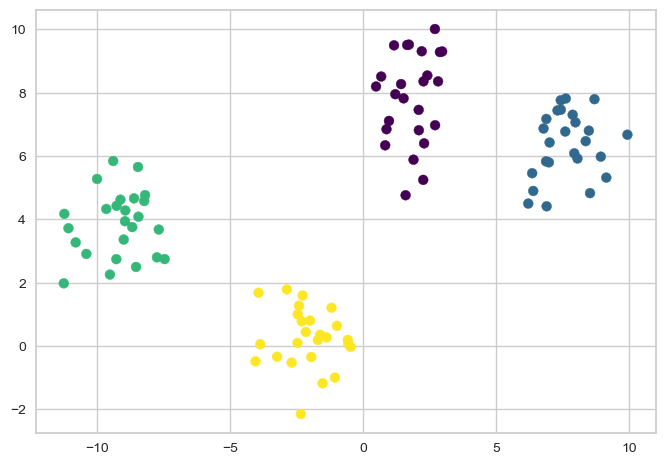

In [492]:
STD = 1.0
N_SAMPLES = 100
N_CLUSTERS = 4

# Generate sample data
X, y = make_blobs(n_samples=N_SAMPLES, n_features=2, centers=N_CLUSTERS, cluster_std=STD, random_state=20)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plt.show()

In [493]:
# Generate graph from sample data using k-nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', radius=STD).fit(X)
distances, indices = nbrs.kneighbors(X)

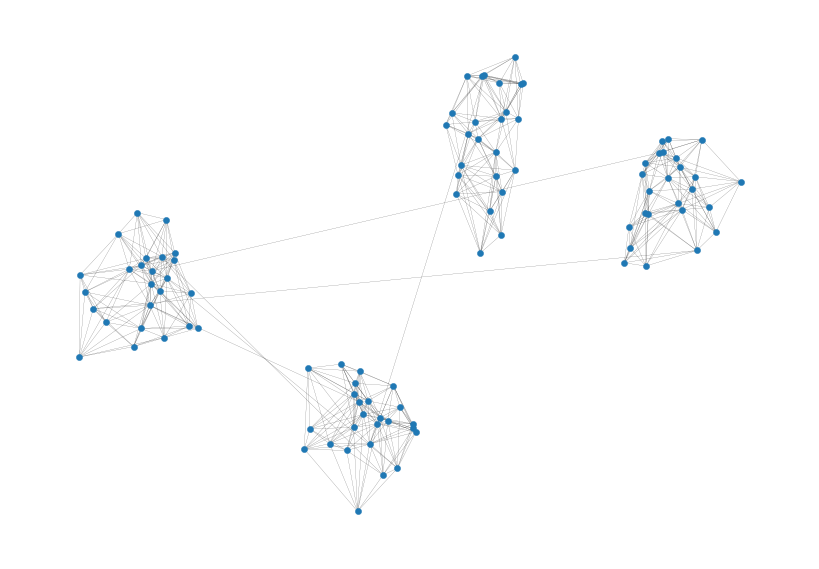

In [687]:
# Plot k-nearest neighbors graph
import networkx as nx
G = nx.Graph()
for i in range(X.shape[0]):
    for j in range(1, indices.shape[1]):
        G.add_edge(i, indices[i, j], weight=np.exp(-distances[i, j] / (2 * STD ** 2)))

# Add random edges to graph to increase connectivity
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        if np.random.rand() < 0.001:
            G.add_edge(i, j, weight=np.exp(-np.linalg.norm(X[i, :] - X[j, :]) / (2 * STD ** 2)))

# Plot graph with nodes at sample data points
pos = {i: X[i, :] for i in range(X.shape[0])}
nx.draw(G, pos, node_size=20, width=0.1)
plt.show()

In [691]:
# Calculate affinity matrix
W = nx.adjacency_matrix(G).todense()

/var/folders/xy/2r8t088s2pn_nrnl76p9tkv00000gn/T/ipykernel_86642/429387905.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


In [728]:
# Calculate stationary distribution
phi = np.eye(W.shape[0])
new_phi = np.eye(W.shape[0])

psi = np.ones((W.shape[0],))
new_psi = np.ones((W.shape[0],))

phi_converged = False
psi_converged = False

eps = 1.
for iter in tqdm(range(1000)):
    # Calculate new stationary distribution
    for i in range(W.shape[0]):
        # Calculate sum of W_ij * phi_j
        if not phi_converged:
            sum_phi = phi[i, :].copy()
            # sum_phi[i] += eps
        if not psi_converged:
            sum_psi = psi[i] + eps * (1 - phi[i, i] * psi[i])
        sum_W = 1.
        for j in range(W.shape[1]):
            if i == j:
                continue
            W_ij = W[i, j]
            if not phi_converged:
                sum_phi += W_ij * phi[j, :]
            if not psi_converged:
                sum_psi += W_ij * psi[j]
            sum_W += W_ij
        if not phi_converged:
            new_phi[i, :] = sum_phi / sum_W
        if not psi_converged:
            new_psi[i] = sum_psi / sum_W

    # Check if stationary distribution has converged
    if not phi_converged:
        if iter > 0 and np.linalg.norm(phi - new_phi) < 1e-6:
            phi_converged = True
            print('Phi converged after {} iterations'.format(iter))
        else:
            phi = new_phi.copy()
    if not psi_converged:
        if iter > 0 and np.linalg.norm(psi - new_psi) < 1e-3:
            psi_converged = True
            print('Psi converged after {} iterations'.format(iter))
        else:
            psi = new_psi.copy()
            if phi_converged:
                eps = 0.99 * eps
    if phi_converged and psi_converged:
        break

100%|██████████| 1000/1000 [00:17<00:00, 56.71it/s]


In [727]:
phi

array([[1.85828789e-01, 5.35356673e-02, 5.82483690e-02, ...,
        4.53433889e-14, 5.65786911e-09, 5.21636830e-09],
       [5.35356232e-02, 1.57825751e-01, 5.15723619e-02, ...,
        5.40796377e-14, 6.74473103e-09, 6.21849580e-09],
       [5.82483914e-02, 5.15724279e-02, 2.06008814e-01, ...,
        4.13445226e-14, 5.16006079e-09, 4.75737747e-09],
       ...,
       [4.54235334e-14, 5.42593234e-14, 4.13769642e-14, ...,
        2.23232502e-01, 2.74373110e-07, 2.73388819e-07],
       [5.65947655e-09, 6.74882959e-09, 5.16045172e-09, ...,
        2.74369846e-07, 2.10097417e-01, 5.51827454e-02],
       [5.21830689e-09, 6.22288573e-09, 4.75811592e-09, ...,
        2.73388173e-07, 5.51827639e-02, 2.17698868e-01]])

In [140]:
# Calculate degrsee matrix
D = np.zeros((W.shape[0], W.shape[1]))
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])

In [141]:
# Calculate Laplacian matrix
L = D - W

In [114]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(L)

In [122]:
# Sort eigenvalues in ascending order
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

In [123]:
# Calculate k-means clusters
kmeans = KMeans(n_clusters=4, random_state=20).fit(eigenvectors[:, 1:3])

/opt/homebrew/Caskroom/miniconda/base/envs/peerj/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


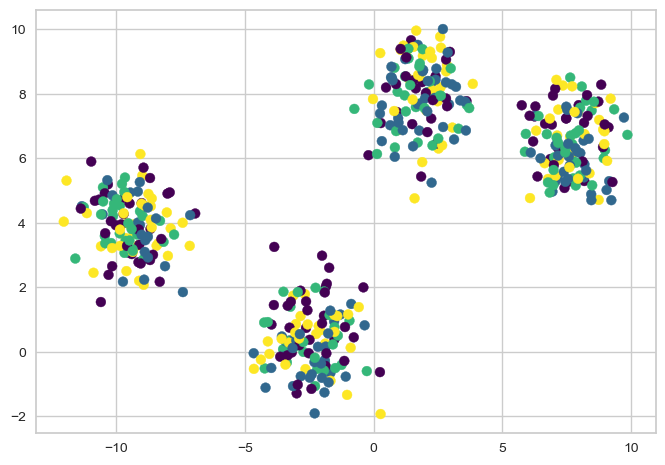

In [124]:
# Plot k-means clusters
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.show()